##Generate a music video

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%%capture
! pip install diffusers transformers

In [21]:
from matplotlib import pyplot as plt
import numpy as np

def plot_array(y, title, x_axis, y_axis, x_aux=None):
    if x_aux is None:
      x = np.arange(y.shape[0])
    else:
      x = x_aux

    plt.title(title)

    plt.xlabel(x_axis)

    plt.ylabel(y_axis)

    plt.plot(x, y, color ="red")
    return plt.show()

In [22]:
import librosa
from IPython.display import Audio

n_mels = 512
fps = 30
offset = 11
duration = 10
num_parts = 3

audio_input = "/content/drive/MyDrive/audio_samples/Tchaikovsky-Swan_Lake_30sec.wav" #path to the song used to generate the music video

wav, sr = librosa.load(audio_input)

Audio(wav, rate=sr)

audio_sections = []
audio_sections_duration = []

samples_part = duration * sr

for i in range(0, len(wav), samples_part):
    end = i + samples_part
    audio_part = wav[i:end]
    audio_sections.append(audio_part)
    audio_sections_duration.append(len(audio_part)/sr)

Audio(audio_sections[2], rate=sr)

0


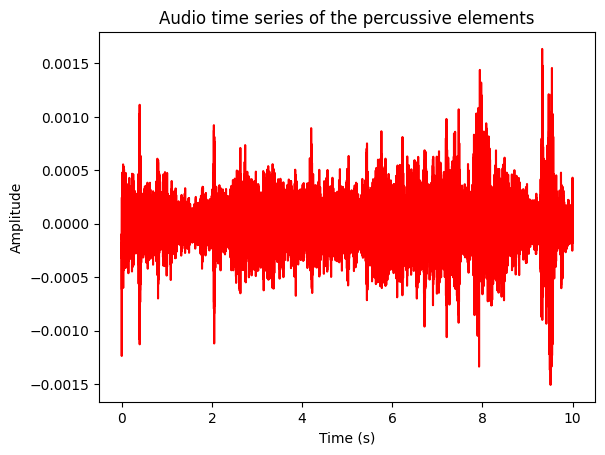

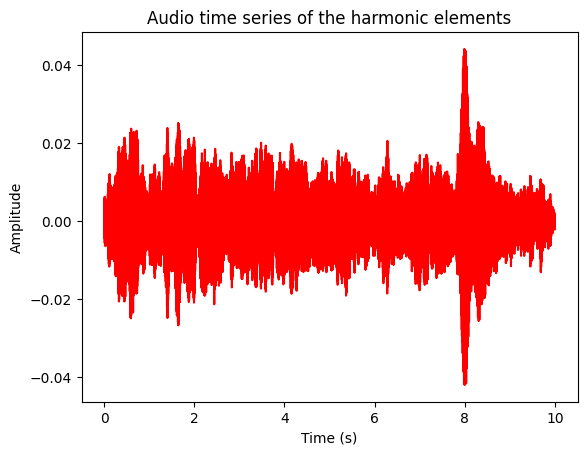

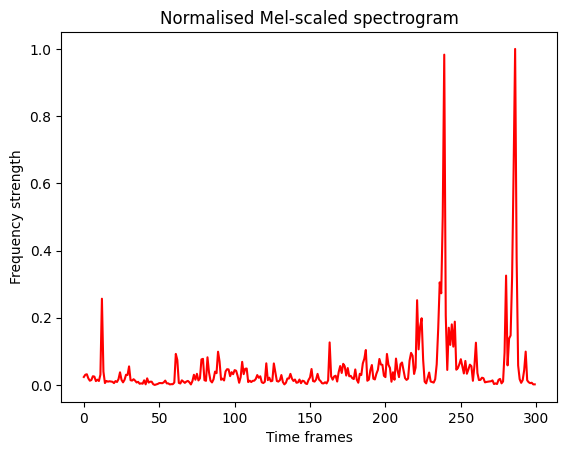

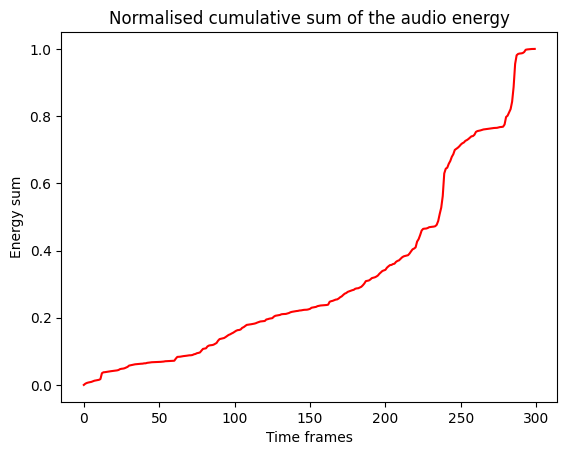

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
1


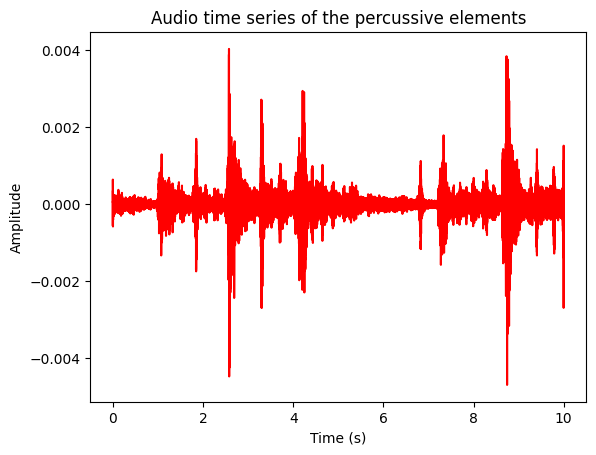

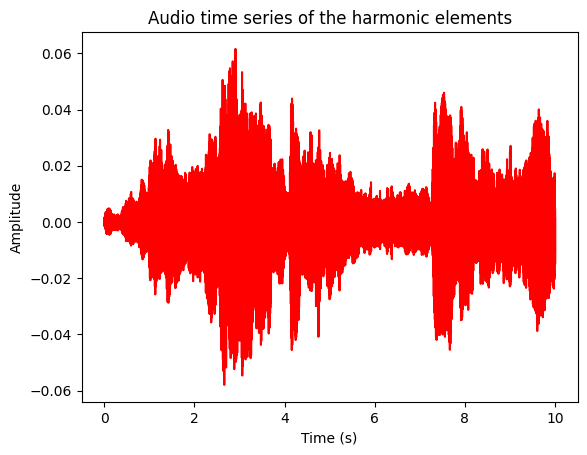

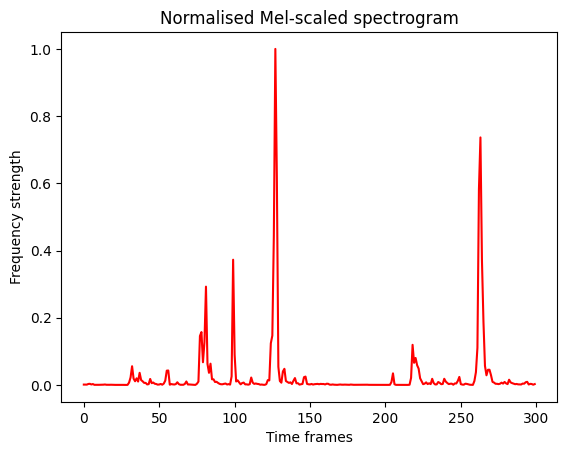

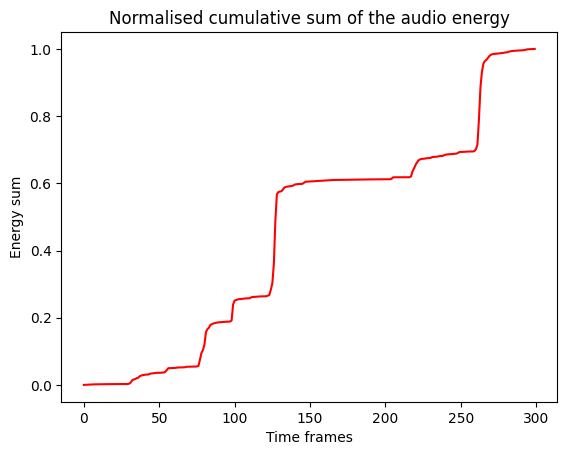

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
2


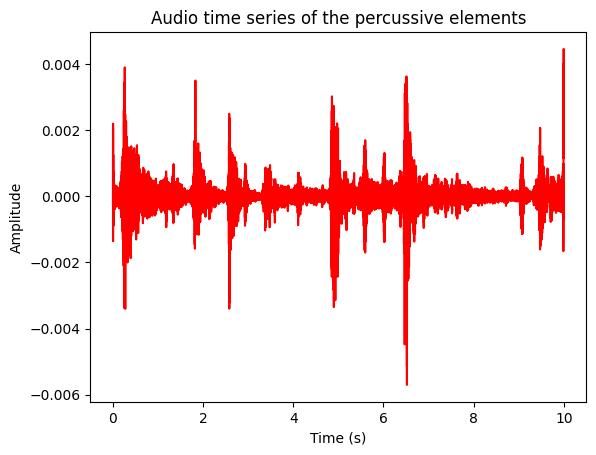

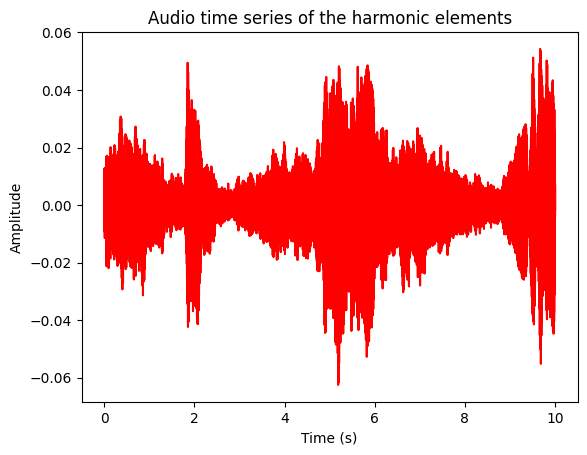

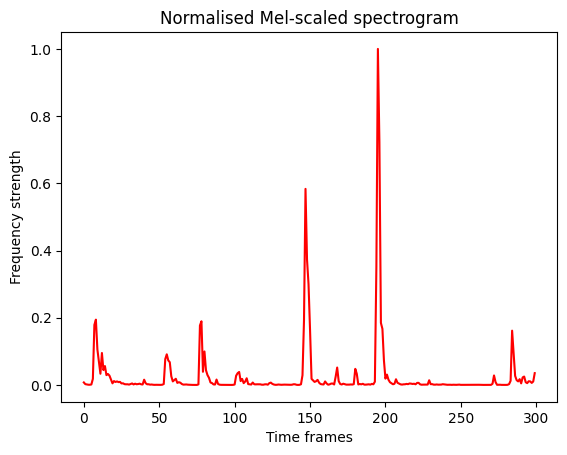

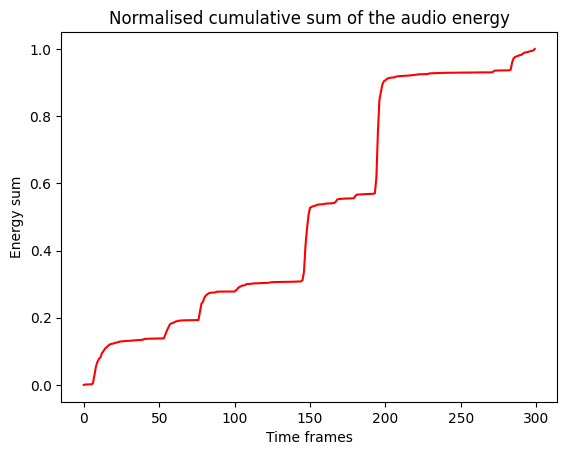

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


In [24]:
T_sections = []
T_sections_linear = [] #for linear transformation testing
T_linear = np.linspace(0, 1, int(duration * fps)) #for linear transformation testing
T_sections_constant = [] #for constant transformation testing
T_constant = np.zeros(int(duration * fps)) #for constant transformation testing

for i in range(len(audio_sections)):

    print(i)
    wav_harmonic, wav_percussive = librosa.effects.hpss(audio_sections[i], margin=(5.0, 5.0)) #values above 5.0 don't seem to change outcomes anymore
    plot_array(wav_percussive, "Audio time series of the percussive elements", "Time (s)", "Amplitude", x_aux=np.arange(len(wav_percussive)) / sr)
    plot_array(wav_harmonic, "Audio time series of the harmonic elements", "Time (s)", "Amplitude", x_aux=np.arange(len(wav_percussive)) / sr)


    # Number of audio samples per frame
    frame_duration = int(sr / fps)

    ## percussive ------------------------------------------------
    # Generate Mel Spectrogram
    spec_raw = librosa.feature.melspectrogram(y=wav_percussive, sr=sr, n_mels=n_mels, hop_length=frame_duration)

    # Obtain maximum value per time-frame
    spec_max = np.amax(spec_raw, axis=0)

    # Normalize all values between 0 and 1
    spec_norm_P = (spec_max - np.min(spec_max)) / np.ptp(spec_max)

    ## harmonic ------------------------------------------------
    # Generate Mel Spectrogram
    spec_raw_H = librosa.feature.melspectrogram(y=wav_harmonic, sr=sr, n_mels=n_mels, hop_length=frame_duration)

    # Obtain maximum value per time-frame
    spec_max_H = np.amax(spec_raw_H, axis=0)

    # Normalize all values between 0 and 1
    spec_norm_H = (spec_max_H - np.min(spec_max_H)) / np.ptp(spec_max_H)

    #------------------------------------------------------------

    spec_norm_H_P = 0.00 * spec_norm_H + 1.00 * spec_norm_P # change depending on the song (a good default for smoother transitions might be 0.20H - 0.80P)

    amplitude_arr_H_P = np.resize(spec_norm_H_P, int(audio_sections_duration[i] * fps))

    plot_array(amplitude_arr_H_P, "Normalised Mel-scaled spectrogram", "Time frames", "Frequency strength")

    # Cumulative sum of audio energy
    T = np.cumsum(amplitude_arr_H_P)

    # Normalize values of T against last element
    T /= T[-1]

    # 0th element not always exactly 0.0. Enforcing that here.
    T[0] = 0.0

    plot_array(T, "Normalised cumulative sum of the audio energy", "Time frames", "Energy sum")

    T_sections.append(T)

    T_sections_linear.append(T_linear) #for linear transformation testing

    T_sections_constant.append(T_constant) #for constant transformation testing

    print("-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+")

#Audio(wav_harmonic, rate=sr)
Audio(wav_percussive, rate=sr)



In [6]:
import torch
from diffusers import StableDiffusionImageVariationPipeline
from PIL import Image
from torchvision import transforms
import numpy as np
import os
from pathlib import Path

# Device setup
device = "cuda"

output_dir = Path('images_walk_with_audio') # change output path
output_dir.mkdir(exist_ok=True, parents=True)

# Load the pre-trained model
sd_pipe = StableDiffusionImageVariationPipeline.from_pretrained(
    "lambdalabs/sd-image-variations-diffusers",
    revision="v2.0",
)
sd_pipe = sd_pipe.to(device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors not found


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/871 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/5.01k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/284 [00:00<?, ?B/s]

image_encoder/config.json:   0%|          | 0.00/703 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/595 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--lambdalabs--sd-image-variations-diffusers/snapshots/a2a13984e57db80adcc9e3f85d568dcccb9b29fc/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--lambdalabs--sd-image-variations-diffusers/snapshots/a2a13984e57db80adcc9e3f85d568dcccb9b29fc/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--lambdalabs--sd-image-variations-diffusers/snapshots/a2a13984e57db80adcc9e3f85d568dcccb9b29fc/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--lambdalabs--sd-image-variations-diffusers/snapshots/a2a13984e57db80adcc9e3f85d568dcccb9b29fc/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [29]:

# Load and preprocess the initial image

# Preprocess the images #transforms.Resize((512, 512) # the user can adjust the video image pixels here
def preprocess_image(image_path, device):
    im = Image.open(image_path).convert("RGB")
    tform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((768, 768), interpolation=transforms.InterpolationMode.BICUBIC, antialias=False
        ),
        transforms.Normalize([0.48145466, 0.4578275, 0.40821073], [0.26862954, 0.26130258, 0.27577711]),
    ])
    return tform(im).unsqueeze(0).to(device)

im1 = "/content/drive/MyDrive/image_samples/countryside_1.png" #AI images generated during the first stage
im2 = "/content/drive/MyDrive/image_samples/countryside_2.png" #AI images generated during the first stage
im3 = "/content/drive/MyDrive/image_samples/countryside_3.png" #AI images generated during the first stage
default = "/content/drive/MyDrive/image_samples/vine-black-painted-swatch.jpg" #we choose a full black image to initiate the video

path_list = [default, im1, im2, im3] #adjust accordingly to the images used

def encode_image(pipe, image):
    with torch.no_grad():
        latents = pipe.vae.encode(image).latent_dist.sample()
        latents = 0.18215 * latents
    return latents

def slerp(t, v0, v1, DOT_THRESHOLD=0.9995):

    if not isinstance(v0, np.ndarray):
        inputs_are_torch = True
        input_device = v0.device
        v0 = v0.cpu().numpy()
        v1 = v1.cpu().numpy()
    dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))

    if np.abs(dot) > DOT_THRESHOLD:
        v2 = (1 - t) * v0 + t * v1
    else:
        theta_0 = np.arccos(dot)
        sin_theta_0 = np.sin(theta_0)
        theta_t = theta_0 * t
        sin_theta_t = np.sin(theta_t)
        s0 = np.sin(theta_0 - theta_t) / sin_theta_0
        s1 = sin_theta_t / sin_theta_0
        v2 = s0 * v0 + s1 * v1

    if inputs_are_torch:
        v2 = torch.from_numpy(v2).to(input_device)
    return v2

z = 0
print("loop:start")
i=0
for j in range(len(T_sections)):
    T = T_sections[j]
    #T = T_sections_linear[j] # for linear tests where the T values are incrementing linearly
    #T = T_sections_constant[j] # for constant tests where the T values are always 0

    if z == 0:
        inp_initial = preprocess_image(path_list[0], device)
        inp_target = preprocess_image(path_list[1], device)
    else:
        index = z + 1
        inp_initial = inp_target
        inp_target = preprocess_image(path_list[index], device)

    latents_initial = encode_image(sd_pipe, inp_initial)
    latents_target = encode_image(sd_pipe, inp_target)
    for k, t in enumerate(T):

        latents_t = slerp(float(t), latents_initial.flatten(), latents_target.flatten()).view_as(latents_initial)

        with torch.no_grad():
            decoded_image = sd_pipe.vae.decode(latents_t / 0.18215).sample
            image = (decoded_image / 2 + 0.5).clamp(0, 1)
            image = transforms.ToPILImage()(image.squeeze().cpu())
            image.save(os.path.join(output_dir, f'frame{i:06d}.png'))
        i+=1
    z+=1



loop:start


In [30]:
import soundfile as sf

sf.write(output_dir / 'audio_test.wav', wav, samplerate=sr)

In [31]:
#change images_walk_with_audio path
! ffmpeg \
  -r {fps} \
  -i /content/images_walk_with_audio/frame%06d.png \
  -i /content/images_walk_with_audio/audio_test.wav \
  -c copy \
  -map 0:v:0 \
  -map 1:a:0 \
  -acodec aac \
  -vcodec libx264 \
  -pix_fmt yuv420p \
  output_walk_with_audio.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [32]:
from IPython.display import HTML
from base64 import b64encode

def visualize_video_colab(video_path):
    mp4 = open(video_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

visualize_video_colab('output_walk_with_audio.mp4')

##Result evaluation

##Measuring Audio-Visual Synchrony/ Rhythm Consistency

In [11]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512549 sha256=0da89f9e866aba8946123f62e301f6ac079a5683fb6b1deea982b7953c061b47
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


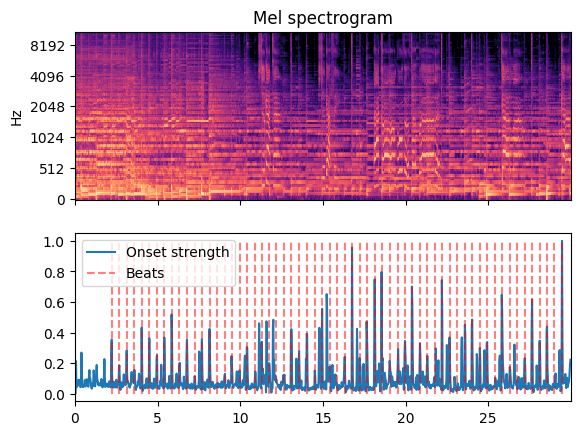

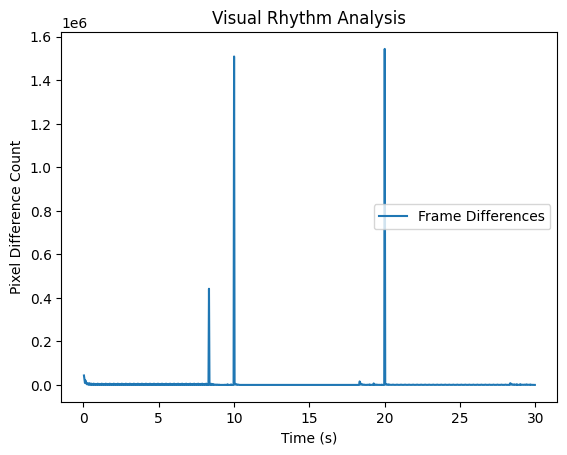

[[ 4.04027211]
 [ 5.85142857]
 [ 8.15020408]
 [13.09605442]
 [14.95365079]
 [16.76480726]
 [18.13478458]
 [18.55274376]
 [20.41034014]
 [22.19827664]
 [23.59147392]
 [24.03265306]
 [25.84380952]
 [27.65496599]
 [28.56054422]
 [29.46612245]]
[[ 8.33333333]
 [10.        ]
 [20.        ]]
Rhythm Consistency: 0.20173072150753688


In [33]:
import cv2
import librosa
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def detect_beats(audio_path, threshold=0.40): #keep this treshold value as it is synchronized/proportional to the visual_rhythm_analysis treshold value
    y, sr = librosa.load(audio_path)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr, onset_envelope=onset_env)
    beat_times = librosa.frames_to_time(beats, sr=sr)
    onset_env_norm = librosa.util.normalize(onset_env)
    #print(onset_env)
    #print(onset_env_norm)

    significant_beats = beat_times[onset_env_norm[beats] > threshold]

    #https://librosa.org/doc/latest/generated/librosa.beat.beat_track.html
    hop_length = 512
    fig, ax = plt.subplots(nrows=2, sharex=True)
    times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)
    M = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)
    librosa.display.specshow(librosa.power_to_db(M, ref=np.max), y_axis='mel', x_axis='time', hop_length=hop_length,ax=ax[0])
    ax[0].label_outer()
    ax[0].set(title='Mel spectrogram')
    ax[1].plot(times, librosa.util.normalize(onset_env),label='Onset strength')
    ax[1].vlines(times[beats], 0, 1, alpha=0.5, color='r', linestyle='--', label='Beats')
    ax[1].legend()

    return significant_beats

beats = detect_beats('/content/drive/MyDrive/audio_samples/Born_and_Raised_JM_30sec.wav') #path to the song used in the music video

def visual_rhythm_analysis(video_path, threshold=225000, min_interval=1000): #keep this treshold value as it is synchronized/proportional to the detect_beats treshold value
    cap = cv2.VideoCapture(video_path)
    frame_times = []
    prev_frame = None
    last_event_time = 0
    diff_frames_values = []
    every_time_stamp = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if prev_frame is not None:
            diff = cv2.absdiff(prev_frame, frame)
            non_zero_count = np.count_nonzero(diff)
            current_time = cap.get(cv2.CAP_PROP_POS_MSEC)

            diff_frames_values.append(non_zero_count)
            every_time_stamp.append(current_time / 1000)  # Convert to seconds

            if non_zero_count > threshold and (current_time - last_event_time) > min_interval:
                frame_times.append(current_time / 1000)  # Convert to seconds
                last_event_time = current_time

        prev_frame = frame

    cap.release()

    # Plotting the frame differences
    fig, ax = plt.subplots()
    ax.plot(every_time_stamp, diff_frames_values, label='Frame Differences')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pixel Difference Count')
    ax.set_title('Visual Rhythm Analysis')
    ax.legend()
    plt.show()

    return frame_times

visual_events = visual_rhythm_analysis("/content/output_walk_with_audio.mp4")

def calculate_rhythm_consistency(beats, visual_events):
    if len(beats) == 0 or len(visual_events) == 0:
        return 0

    # Use DTW to measure similarity between the two sequences
    distance, path = fastdtw(beats, visual_events, dist=euclidean)

    # Normalize the distance by the length of the path to get a consistency score
    rhythm_consistency = 1 / (1 + distance / len(path))
    return rhythm_consistency

beats = np.array(beats).reshape(-1, 1)  # Ensure 2-D array for fastdtw
visual_events = np.array(visual_events).reshape(-1, 1)  # Ensure 2-D array for fastdtw
print(beats)
print(visual_events)
rhythm_consistency = calculate_rhythm_consistency(beats, visual_events)
print("Rhythm Consistency:", rhythm_consistency)
